# Lecture 6: Risk Measures

The previous lecture covered risk mapping, which should output a loss distribution $L_{t+1}. $ This lecture will be conerned with how to make such a distribution useful by introducing several methods for measuring risk. Such methods are used in financial institutions to perform tasks such as pricing insurance premiums, managing assets and determining how much capital one can afford to deploy on an investment given its risk. 

The main topics of discussion are:

 1. Basics of risk measurement
 2. Axiomization of risk measure theory
 3. Important risk measures
 4. Standard techniques for calculating VaR
 


In [15]:
#Importing standard libraries

import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Basics of Risk Measurement
There are several ways to measure risk. In fact, we have already covered a few examples throughout this course. For example, the option _greeks_ are measures of an option price's sensitivities to various factors, which is essentially a set of risk measures. However, the greeks are limited in the sense where they cannot be aggrigated (or be combined into a single measure), which is usually necessary in risk management. Another notable risk measure are the scenario-based risk measures.

For example, consider a set of risk factor changes $\chi = \{\vec{x}_1, \dots, \vec{x}_n\}$ and a set of weights $\vec{w} = \{w_1, \dots, w_n\} \in [0,1]^n$. Given a portfolio with an associated loss operator $l_{[t]}$, the risk is now taken to be the following function: 

$$\Psi_{[\chi,w]} = \max\{w_1l_{[t]}(\vec{x_1}),\dots, w_nl_{[t]}(\vec{x_n})\}$$

In other words, the risk is taken to be the maximum loss adjusted for its weight (probability of occurence). Whilst this approach doesn't tend to be highly looked up upon, it is very practical and tends to be used by exchanges such as the Chicago Mercantile Exchange and the Hong Kong Exchanges and Clearing which both use it to determine the margins for traders (see SPAN). 

The problems with scenario-based measures is that they are not derived from any theory and that it is usually difficult to accurately determine the weights. For this reason, we will stick to the more common approach of defining risk measures based on loss distributions. One can justify this method with the following statements:

 - Losses are the focus of risk management. Certain moments of distributions can provide monetary indicators
 - Loss distributions can be summarized on each _aggrigation level_ (individual investment, portfolio, company)
 - Diversification effects can be modeled
 - Loss distributions can be compared with eachother
 
And the two disadvantages being 1. you need a lot of data and 2. you may have incorrect assumptions, fit the data to the wrong model, use wrong risk mapping, etc. Although one can easily tell that the disadvantages are not in the the method itself but how it is implemented (i.e one must be very careful with implementing loss-distribution). Another important point is that it is generally bad practice to set the loss distribution as a risk measure (think about presenting a distribution to a CEO -- he doesn't care, he wants a number, eg. risk is $100MM). For this reason, one must then think about _what_ they want from a loss distribution. For example, an insurance business will likely be concerned with the expected value and/or median of this distribution.



#### Python Implementation

Given that there isn't much python implementation one can do for this section, a good idea would be to create a function that maps an input loss operator `l_t(x)`, weight vector `w` and risk factor change `chi` to an output risk measure `Phi` that assumes a scenario based model.

In [1]:
def Phi(l_t, w, chi):
    risks = [w[i]*l_t(chi[i]) for i in range(len(w))]
    return max(risks)

## Axiomatic Risk Measure Theory

The following section is all based on Artzner et al. (1999) which is linked in the "Further Reading" section. The goal is to define valid or _coherent_ risk measures using a set of axioms, and to use those set of axioms to judge commonly used risk measures such as VaR and expected shortfall.

Consider a probability triple $(\mathbf{\Omega},\mathcal{F}, \mathbb{P})$ and a time horizon $\Delta$. We then denote the set of all random variables which are almost surely finite on $(\mathbf{\Omega},\mathcal{F})$ as $L^0(\mathbf{\Omega},\mathcal{F}, \mathbb{P})$. A financial risk $\mathcal{M}$ is then said to be a subset of $L^0$, or $\mathcal{M} \subset L^0(\mathbf{\Omega},\mathcal{F}, \mathbb{P})$. 

$\mathcal{M}$ is also said to be a convex cone, meaning that given two risks (RVs) $X, Y \in \mathcal{M}$ and a scalar $a > 0$

$$X + Y \in \mathcal{M}$$

and 

$$aX \in \mathcal{M}$$


A risk measure $\mathcal{V}: \mathcal{M} \rightarrow \mathbb{R}$ is a function that maps a random variable $L \in \mathcal{M}$ to a real value. $\mathcal{V}(L)$ is interpreted as the amount of capital that must be added to the risk $L$ to make it acceptible for a decision maker. If $\mathcal{V}(L) > 0$ the risk is acceptable and $-\mathcal{V}(L)$ can be taken from the position without the risk becoming unacceptable. For example, if a bank finds that $\mathcal{V}(L) = -5000$EUR for one of its accounts, then one can withdraw up to 5000EUR without it causing any risk. If the measure was a positive number, say +5000EUR, then 5000 must be added into the account. 


The following is the set of axioms that a risk measure $\mathcal{V}: \mathcal{M} \rightarrow \mathbb{R}$ must satisfy to be a coherent risk measure:


**Axiom 1: Translational Invariance**

A risk measure $\mathcal{V}(L)$ is translationally invariant if for every risk $L \in \mathcal{M}$ and any amount of capital $l \in \mathbb{R}$

$$\mathcal{V}(L + l) = \mathcal{V}(L) + l$$

This means that by adding a safe amount of cash $l$, the amount of capital necessary to make the risk acceptable is reduced exactly by $l$.


**Axiom 2: Subadditivity**

For $L_1, L_2 \in \mathcal{M}$


$$\mathcal{V}(L_1 + L_2) \leq \mathcal{V}(L_1) + \mathcal{V}(L_2)$$

In other words, the composite risk of $L_1 + L_2$ will always be less than the sum of risks of $L_1$ and $L_2$. This statement axiomatically justifies diversification. Neglecting this axiom in portfolio optimization may lead to optimal portfolios being highly concentrated (and therefore risky).


**Axiom 3: Positive Homogeniety**

For all $L \in \mathcal{M}$ and every $\lambda > 0$


$$\mathcal{V}(\lambda L) = \lambda\mathcal{V}(L)$$

By adding a larger amount of capital at risk will correspond to a proportially scaled risk ratio (a simple example being CFDs). This may not be obvious because at a certain point of adding capital, there will be liquidity concerns.

**Axiom 4: Monotonicity**

For $L_1, L_2 \in \mathcal{M}$ such that $L_1 \leq L_2$,

$$\mathcal{V}(L_1) \leq \mathcal{V}(L_2)$$

This axiom becomes obvious if you state it as: positions that lead to higher losses require more risk capital for hedging.

**Definition 5: Coherent Risk Measure** 

Any risk measure $\mathcal{V}$ whose domain includes the convex cone $\mathcal{M}$ is said to be coherent on $\mathcal{M}$ iff Axioms 1-4 are satistfied.


**Note 6: Convex Risk Measures**

In axiom 3, I state that in practice, for large enough positions (i.e $\lambda >> 0$), there will be liquidity concerns. For example a large hedge fund trading penny stocks will corner the market and make the price react to the size of the trade itself. This implies $\mathcal{V}(\lambda L) > \lambda \mathcal{V}(L)$. It is for this reason that subadditivity and homeoginity definitions are treated loosely and sometimes requiring only a weaker property called convexity, or

$$\mathcal{V}(\lambda L_1 + (1 - \lambda)L_2) \leq \lambda\mathcal{V}(L_1) + (1 - \lambda)\mathcal{V}( L_2)$$

where $L_1, L_2 \in \mathcal{M}$ and $\lambda \in [0,1]$.

These axioms and concepts may seem highly abstract and theoretical but when first studied, the authors looked at various practiced risk measures and found flaws in many that did not satisfy the axioms above.


## Important Risk Measures

Now let us look at some concrete examples of risk measures of a given loss distribution, $\mathcal{V}(L)$. Given that the loss distribution is simply a probability distribution, there are several measures that should seem intuitive. Namely,

 1. The mean loss $\mathcal{V}(L) = \mathbb{L}$
 2. The variance $\mathcal{V}(L) = var(L)$
 3. The maximum loss $\mathcal{V} = \inf\{l \in \mathbb{R}: F_{L}(l) = 1\}$, where $\inf$ denotes the infinum 
 
However, each of those measures have their own disadvantages. For example, the variance of a distribution is non-negative (which, based on the definition above, should raise some immediate concerns). Also, the mean and maximum loss are not robust for extreme values and in practice, tend to give pessimistic results (especially the max. loss). Finally, the maximum loss is not even a function of the loss distribution.

The risk measure that is most commonly used is know as the Value at Risk (VaR). It is used by commercial banks and various other types of firms as it has been deemed the industry standard for measuring market price and credit risk.  VaR, however, is not a coherent risk measure, as it does not, in general, satisfy the axiom of subadditivity _(Axiom 2)_. It rather only satisfies it under the assumption of an elliptical loss distribution.

In simple terms, the Value at Risk gives us the worst possible outcome given a confidence level. For example, "what is the worst case scenario of buying MSFT stock for one day, given a 95\% confidence level"? It is formally defined as

**Definition 7: Value at Risk (VaR)**

The Value at Risk of a portfolio with a given confidence level $\alpha \in (0,1)$ is given by the smallest number $l$, such that the probability that the loss $L$ exceeds $l$ is not greater than $(1 - \alpha)$, or

$$VaR_\alpha = \inf\{l \in \mathbb{R}: P(L > l) \leq (1-\alpha)\}\\ = \inf\{l \in \mathbb{R}: F_L(l) \geq \alpha\}$$
<hr>
In other words, it is a quantile such that the losses are greater than a $1-\alpha$ probability, as indicated in the following image: 

<img src="assets/var.png" width=500>


In practice, the confidence $\alpha$ is usually set to either 0.95 or 0.99 and the time horizon $\Delta$ is usually set to 1 or 10 days in market risk management and 1 year in credit risk management. The figure above shows the standard $\alpha = 0.95, \Delta = 10$days for a market portfolio. 


The VaR makes no statement about what happens beyond $1-\alpha$, but only about the losses at that level. A variation of VaR, called the mean-VaR, is also used and it is given by 

$$VaR_\alpha^{mean} = VaR_\alpha - \mathbb{E}(L) $$

Although from a statistical perspective, both measures are nothing but the quantiles of the loss distribution.

**Definition 8: Generalized Inverse and Quantile Function**

If $T: \mathbb{R} \rightarrow \mathbb{R}$ is an increasing function, then its generalized inverse $T^{\leftarrow}$ is defined as 

$$T^{\leftarrow}(y) = \inf\{x\in \mathbb{R}: T(x)\geq y\}$$

If $T$ is continuous and strictly increasing, then $T^{\leftarrow} = T^{-1}$ (i.e the generalized inverse is equal to the usual inverse)

Given a distribution $F$, then its _quantile function_ is $F^{\leftarrow}$. Their values for $\alpha \in (0,1)$ are

$$F^{\leftarrow}(\alpha) = \inf\{x \in R: F(x) \geq \alpha\}$$
<hr>

Assuming a normally distributed loss distribution $L \sim N(\mu,\sigma^2)$, the $VaR_\alpha$ is given by

$$VaR_{\alpha} = \mu + \sigma\Phi^{-1}(\alpha)$$

where $\Phi(\alpha)$ is the standard normal distribution. 

Similarly, assuming $(L - \mu)/\sigma$ follows a standard $t$ distribution with $\nu$ degrees of freedom, the VaR is given by

$$VaR_{\alpha} = \mu + \sigma t_\nu^{-1}(\alpha)$$

#### Python Implementation

We will be using the historical data of \\$AMD daily returns for the past 5 years to estimate the VaR of holding it for a day with 95percent confidence, i.e $\alpha = 0.95, \Delta = 1$day. We will assume a normal distribution

In [157]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance

def get_stock_price(ticker, start='2016-01-01', end='2022-01-01',price_type = 'Adj Close'):
    return data.DataReader(ticker,'yahoo',start,end)[price_type]


In [158]:
AMD_daily_price = get_stock_price('AMD') #Getting Price Data

#Getting the simple daily returns
AMD_daily_return=[(AMD_daily_price[i+1]-AMD_daily_price[i])/AMD_daily_price[i] for i in range(len(AMD_daily_price)-1)]


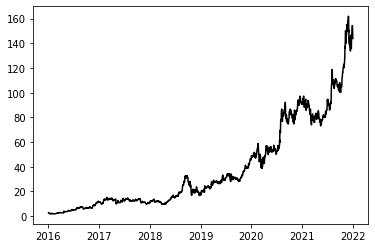

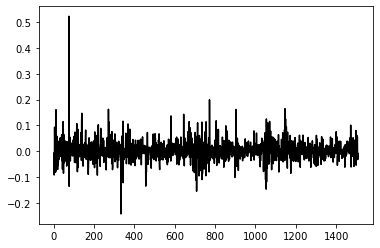

In [198]:
plt.plot(AMD_daily_price, color='black')
plt.show()
plt.plot(AMD_daily_return, color='black')
plt.show()

Let us now calculate the VaR (alpha = 0.95) and plot 

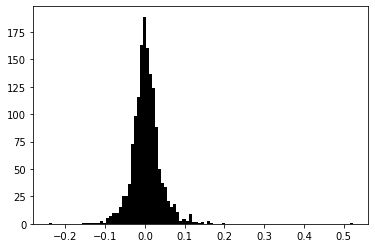

VaR_0.95 =  -0.09165771703267331


In [279]:
VaR = np.percentile(AMD_daily_return,0.95)

plt.hist(AMD_daily_return,bins=100,color='black') #Plotting Histogram
plt.show()

print('VaR_0.95 = ',VaR)

As you can see, we get a VaR of $\sim$ -0.09 (i.e roughly 9 percent loss). Assuming a normal distribution, let us compare this to the value we get assuming a normal distribution.

In [290]:
from scipy.stats import norm 

mu,sigma = norm.fit(AMD_daily_return)

norm_VaR = mu + sigma*-1.644854 #mu +sigma*Z_score
norm_VaR

-0.060794078105646916

We get a -6percent VaR -- quite different from the actual value. 


<hr>


As mentioned above, the VaR is not coherent.  For this reason, people sought out to design risk measures with similar properties as the VaR but also satisfiy the four axioms above. The most notable being the expected shortfall (also called Conditional VaR or CVaR). The VaR finds the minimum loss $l$ with given probability $1 - \alpha$. The expected shortfall, on the other hand, is defined as the average loss of the interval $P(L \geq l)$, or more formally

**Definition 9: Expected Shortfall (CVaR)**

For a loss $L$ with $\mathbb{E}(L) < \infty$ and $F_L$ the distribution function, the expected shortfall at the confidence level $\alpha \in (0,1)$ is defined as 

$$ES_\alpha = CVaR_\alpha = \frac{1}{1 - \alpha}\int_{\alpha}^{1}F_L^{\leftarrow}(u)du$$


or equivalently 

$$ES_\alpha = \mathbb{E}(L|L \geq VaR_\alpha)$$


i.e the average loss that is worst than the VaR.

<hr>

This measure, unlike the VaR, gives us information beyond the "minimum" loss of at a given confidence. It is also a coherent measure (Acerbi and Bac, 2002). A disadvantage of the ES, however, is that it is difficult to backtest.

The following image from "QRM" by Mcneil, Fret and Embrechts shows a loss distribution with the VaR and ES shown (with $\alpha$ = 0.95):

<img src="assets/esvar.png" width=500>


### Backtesting

To do: 

 - Do backtesting 010010101 etc
 - Three methods of implementation
 - Implement 1,2, or 3 of them
